In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from openparticle.hamiltonians.yukawa_hamiltonians import yukawa_hamiltonian
from openparticle import ParticleOperator
import numpy as np
import cirq
import matplotlib.pyplot as plt

import sys, os
sys.path.append(os.path.join(os.path.dirname(os.path.realpath('__file__')), '../../..'))
sys.path.append(os.path.join(os.path.dirname(os.path.realpath('__file__')), '../..'))
from src.lobe.asp import get_target_state, add_prepare_circuit
from src.lobe.rescale import get_number_of_active_bosonic_modes, rescale_coefficients
from src.lobe.system import System
from colors import *
from src.lobe.lcu import LCU
from lobe.yukawa import _determine_block_encoding_function
from src.lobe._utils import translate_antifermions_to_fermions
from src.lobe.index import index_over_terms
from src.lobe.metrics import CircuitMetrics
from tests._utils import _validate_block_encoding
from functools import partial
from openparticle import generate_matrix
from src.lobe._utils import get_basis_of_full_system

/Users/williamsimon/Desktop/Research/SparseOracle/lobe/lib/python3.9/site-packages/cotengra/hyperoptimizers/hyper.py:33: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(
/Users/williamsimon/Desktop/Research/SparseOracle/lobe/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-02-07 18:25:48,606	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [3]:
def lobotomize(resolution, max_bosonic_occupancy):
    operator = yukawa_hamiltonian(res = resolution, g = 1, mf = 1, mb = 1)
    operator = translate_antifermions_to_fermions(operator).normal_order()
    terms = operator.group()
    
    number_of_block_encoding_anillae = 3 
    index_register = [cirq.LineQubit(-i - 2) for i in range(int(np.ceil(np.log2(len(terms)))))]
    block_encoding_ancillae = [cirq.LineQubit(-100 - i - len(index_register)) for i in range(number_of_block_encoding_anillae)]
    ctrls = ([cirq.LineQubit(0)], [1])
    clean_ancillae = [cirq.LineQubit(i + 100) for i in range(100)]
    system = System(operator.max_mode + 1, max_bosonic_occupancy, 1000, True, False, True)

    block_encoding_functions = []
    rescaling_factors = []
    for term in terms:
        be_func, rescaling_factor = _determine_block_encoding_function(
            term, system, block_encoding_ancillae, clean_ancillae=clean_ancillae
        )
        block_encoding_functions.append(be_func)
        rescaling_factors.append(rescaling_factor)


    rescaled_coefficients, overall_rescaling_factor = rescale_coefficients(
        [term.coeffs[0] for term in terms],
        rescaling_factors
    )
    target_state = get_target_state(rescaled_coefficients)
    
    # Generate Circuit
    gates = []
    metrics = CircuitMetrics()

    gates.append(cirq.X.on(ctrls[0][0]))
    _gates, _metrics = add_prepare_circuit(index_register, target_state, clean_ancillae=clean_ancillae)
    gates += _gates
    metrics += _metrics

    _gates, _metrics = index_over_terms(index_register, block_encoding_functions, clean_ancillae, ctrls=ctrls)
    gates += _gates
    metrics += _metrics

    _gates, _metrics = add_prepare_circuit(index_register, target_state, dagger=True, clean_ancillae=clean_ancillae)
    gates += _gates
    metrics += _metrics
    gates.append(cirq.X.on(ctrls[0][0]))

    circuit = cirq.Circuit(gates)
    _validate_block_encoding(circuit, system, overall_rescaling_factor, operator, len(index_register) + number_of_block_encoding_anillae, max_bosonic_occupancy, max_qubits=16, using_pytest=False)

    return  metrics, overall_rescaling_factor, len(index_register) + number_of_block_encoding_anillae, system.number_of_system_qubits

In [4]:
def lcu_ify(resolution, max_bosonic_occupancy):
    operator = yukawa_hamiltonian(res = resolution, g = 1, mf = 1, mb = 1)
    operator = translate_antifermions_to_fermions(operator).normal_order()
    
    lcu = LCU(operator, max_bosonic_occupancy=max_bosonic_occupancy, zero_threshold=1e-6)
    ctrls = ([cirq.LineQubit(-1000000)], [1])
    circuit = cirq.Circuit()
    circuit += cirq.X.on(ctrls[0][0])
    circuit += lcu.get_circuit(ctrls=ctrls)
    circuit += cirq.X.on(ctrls[0][0])
    fake_sys = System(1, max_bosonic_occupancy, 1000 + lcu.number_of_index_qubits, operator.has_fermions, operator.has_antifermions, operator.has_bosons)
    _validate_block_encoding(circuit, fake_sys, lcu.one_norm, operator, len(lcu.index_register), max_bosonic_occupancy, max_qubits=16, using_pytest=False)

    return lcu.circuit_metrics, lcu.one_norm, len(lcu.index_register), lcu.number_of_system_qubits

In [5]:
resolutions = range(2, 8)
bosonic_cutoff = 3

print("LOBE")
LOBE_DATA = [lobotomize(resolution, bosonic_cutoff) for resolution in resolutions]
print("LCU")
LCU_DATA = [lcu_ify(resolution, bosonic_cutoff) for resolution in resolutions]

LOBE
Too many qubits to validate: 21
Too many qubits to validate: 26
Too many qubits to validate: 31
Too many qubits to validate: 36
Too many qubits to validate: 41
Too many qubits to validate: 46
LCU
Too many qubits to validate: 19
Too many qubits to validate: 26
Too many qubits to validate: 31
Too many qubits to validate: 36
Too many qubits to validate: 41
Too many qubits to validate: 46


In [6]:
# bosonic_cutoff = 3
# operator_norms = []
# for resolution in resolutions:
#     operator = yukawa_hamiltonian(res = resolution, g = 1, mf = 1, mb = 1)
#     operator = translate_antifermions_to_fermions(operator).normal_order()
#     full_fock_basis = get_basis_of_full_system(
#         operator.max_mode + 1,
#         bosonic_cutoff,
#         has_fermions=True,
#         has_antifermions=False,
#         has_bosons=True,
#     )
#     expected_unitary = generate_matrix(operator, full_fock_basis)
#     operator_norms.append(np.linalg.norm(expected_unitary, ord=2))
#     print(resolution, operator_norms[-1])

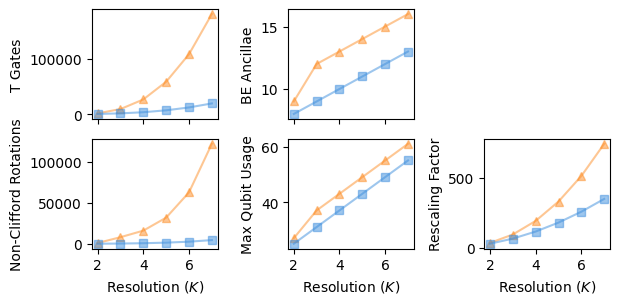

In [10]:
fig, axes = plt.subplots(2, 3, figsize=(16 / 2.54, 8 / 2.54))

axes[0][0].plot(resolutions, [4*LCU_DATA[i][0].number_of_elbows for i in range(len(resolutions))], color=ORANGE, marker='^', alpha = 0.5)
axes[0][0].plot(resolutions, [4*LOBE_DATA[i][0].number_of_elbows for i in range(len(resolutions))], color=BLUE, marker='s', alpha = 0.5)
axes[0][0].set_ylabel("T Gates")
axes[0][0].set_xticklabels([])

axes[1][0].plot(resolutions, [LCU_DATA[i][0].number_of_nonclifford_rotations for i in range(len(resolutions))], color=ORANGE, marker='^', alpha = 0.5)
axes[1][0].plot(resolutions, [LOBE_DATA[i][0].number_of_nonclifford_rotations for i in range(len(resolutions))], color=BLUE, marker='s', alpha = 0.5)
axes[1][0].set_ylabel("Non-Clifford Rotations")
axes[1][0].set_xlabel("Resolution ($K$)")

axes[0][1].plot(resolutions, [LCU_DATA[i][2] for i in range(len(resolutions))], color=ORANGE, marker='^', alpha = 0.5)
axes[0][1].plot(resolutions, [LOBE_DATA[i][2] for i in range(len(resolutions))], color=BLUE, marker='s', alpha = 0.5)
axes[0][1].set_ylabel("BE Ancillae")
axes[0][1].set_xticklabels([])
# axes[0][1].set_yticks([0, 5, 10])

axes[1][1].plot(resolutions, [LCU_DATA[i][0].ancillae_highwater() + LCU_DATA[i][2] + LCU_DATA[i][3] + 1 for i in range(len(resolutions))], color=ORANGE, marker='^', alpha = 0.5, label="LCU")
axes[1][1].plot(resolutions, [LOBE_DATA[i][0].ancillae_highwater() + LOBE_DATA[i][2] + LCU_DATA[i][3] + 1 for i in range(len(resolutions))], color=BLUE, marker='s', alpha = 0.5, label="LOBE")
axes[1][1].set_ylabel("Max Qubit Usage")
axes[1][1].set_xlabel("Resolution ($K$)")
# axes[1][1].set_yticks([0, 10, 20, 30])

axes[1][2].plot(resolutions, [LCU_DATA[i][1] for i in range(len(resolutions))], color=ORANGE, marker='^', alpha = 0.5)
axes[1][2].plot(resolutions, [LOBE_DATA[i][1] for i in range(len(resolutions))], color=BLUE, marker='s', alpha = 0.5)
# axes[1][2].plot(resolutions, [operator_norms[i] for i in range(len(resolutions))], color="black", marker='x', ls='--', alpha = 0.5)
axes[1][2].set_ylabel("Rescaling Factor")
axes[1][2].set_xlabel("Resolution ($K$)")

fig.delaxes(axes[0][2])
plt.tight_layout()
# axes[2][0].legend(loc='upper center', bbox_to_anchor=(1.5, 0.75),
#           fancybox=True, shadow=True, ncol=1)
# plt.savefig("../../../manuscript/figures/static_yukawa.pdf", dpi=300)

In [8]:
[LOBE_DATA[i][3] for i in range(len(resolutions))]

[12, 18, 24, 30, 36, 42]

In [9]:
[LCU_DATA[i][3] for i in range(len(resolutions))]

[8, 12, 16, 20, 24, 28]

In [13]:
operator = yukawa_hamiltonian(res = 4, g = 1, mf = 1, mb = 1)
operator = translate_antifermions_to_fermions(operator).normal_order()
operator.max_bosonic_mode, operator.max_fermionic_mode, operator.max_antifermionic_mode

(3, 7, None)

In [19]:
operator.to_paulis(operator.max_fermionic_mode, max_bosonic_mode=operator.max_bosonic_mode, max_bosonic_occupancy=3).n_qubits

16

In [1]:
from openparticle.hamiltonians.yukawa_hamiltonians import yukawa_hamiltonian
import matplotlib.pyplot as plt
import numpy as np

import sys, os
sys.path.append(os.path.join(os.path.dirname(os.path.realpath('__file__')), '../..'))
sys.path.append(os.path.join(os.path.dirname(os.path.realpath('__file__')), '../../..'))

from colors import *
import pickle

/Users/williamsimon/Desktop/Research/SparseOracle/lobe/lib/python3.9/site-packages/cotengra/hyperoptimizers/hyper.py:33: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(
/Users/williamsimon/Desktop/Research/SparseOracle/lobe/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-02-08 20:31:00,857	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [19]:
with open('full_yukawa_7_2_5.pickle', 'rb') as handle:
    (LCU_DATA, LCU_PIECEWISE_DATA, LOBE_DATA, operator_norms, bosonic_cutoff, resolution_range) = pickle.load(handle)

numbers_of_modes = []
for resolution in resolution_range:
    operator = yukawa_hamiltonian(res=resolution, g=1, mf=1, mb=1)
    operator.remove_identity()
    total_number_of_modes = 0
    if operator.max_fermionic_mode is not None:
        total_number_of_modes += operator.max_fermionic_mode + 1
    if operator.max_bosonic_mode is not None:
        total_number_of_modes += operator.max_bosonic_mode + 1
    numbers_of_modes.append(total_number_of_modes)

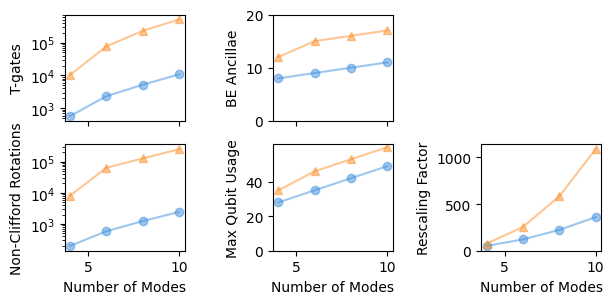

In [20]:
fig, axes = plt.subplots(2, 3, figsize=(16 / 2.54, 8 / 2.54))

axes[0][0].plot(
    numbers_of_modes,
    [(4 * LOBE_DATA[i][0].number_of_elbows) + LOBE_DATA[i][0].number_of_t_gates for i in range(len(numbers_of_modes))],
    color=BLUE,
    marker="o",
    alpha=0.5,
    label="LOBE",
)
axes[0][0].plot(
    numbers_of_modes,
    [(4 * LCU_DATA[i][0].number_of_elbows) + LCU_DATA[i][0].number_of_t_gates for i in range(len(numbers_of_modes))],
    color=ORANGE,
    marker="^",
    alpha=0.5,
    label="LCU",
)
# axes[0][0].plot(
#     numbers_of_modes,
#     [(4 * LCU_PIECEWISE_DATA[i][0].number_of_elbows) + LCU_PIECEWISE_DATA[i][0].number_of_t_gates for i in range(len(numbers_of_modes))],
#     color=GREEN,
#     marker="s",
#     alpha=0.5,
#     label="LCU",
# )
axes[0][0].set_ylabel("T-gates")
axes[0][0].set_xticklabels([])
axes[0][0].set_yscale("log")

axes[1][0].plot(
    numbers_of_modes,
    [
        LOBE_DATA[i][0].number_of_nonclifford_rotations
        for i in range(len(numbers_of_modes))
    ],
    color=BLUE,
    marker="o",
    alpha=0.5,
    label="LOBE",
)
axes[1][0].plot(
    numbers_of_modes,
    [
        LCU_DATA[i][0].number_of_nonclifford_rotations
        for i in range(len(numbers_of_modes))
    ],
    color=ORANGE,
    marker="^",
    alpha=0.5,
    label="LCU",
)
# axes[1][0].plot(
#     numbers_of_modes,
#     [
#         LCU_PIECEWISE_DATA[i][0].number_of_nonclifford_rotations
#         for i in range(len(numbers_of_modes))
#     ],
#     color=GREEN,
#     marker="s",
#     alpha=0.5,
#     label="LCU",
# )
axes[1][0].set_ylabel("Non-Clifford Rotations")
axes[1][0].set_xlabel("Number of Modes")
axes[1][0].set_yscale("log")


axes[0][1].plot(
    numbers_of_modes,
    [LOBE_DATA[i][2] for i in range(len(numbers_of_modes))],
    color=BLUE,
    marker="o",
    alpha=0.5,
    label="LOBE",
)
axes[0][1].plot(
    numbers_of_modes,
    [LCU_DATA[i][2] for i in range(len(numbers_of_modes))],
    color=ORANGE,
    marker="^",
    alpha=0.5,
    label="LCU",
)
# axes[0][1].plot(
#     numbers_of_modes,
#     [LCU_PIECEWISE_DATA[i][2] for i in range(len(numbers_of_modes))],
#     color=GREEN,
#     marker="s",
#     alpha=0.5,
#     label="LCU",
# )
axes[0][1].set_ylabel("BE Ancillae")
axes[0][1].set_xticklabels([])
axes[0][1].set_yticks([0, 10, 20])

axes[1][1].plot(
    numbers_of_modes,
    [
        LCU_DATA[i][0].ancillae_highwater() + LCU_DATA[i][2] + LCU_DATA[i][3] + 1
        for i in range(len(numbers_of_modes))
    ],
    color=ORANGE,
    marker="^",
    alpha=0.5,
    label="LCU",
)
axes[1][1].plot(
    numbers_of_modes,
    [
        LOBE_DATA[i][0].ancillae_highwater()
        + LOBE_DATA[i][2]
        + LOBE_DATA[i][3]
        + 1
        for i in range(len(numbers_of_modes))
    ],
    color=BLUE,
    marker="o",
    alpha=0.5,
    label="LOBE",
)
# axes[1][1].plot(
#     numbers_of_modes,
#     [
#         LCU_PIECEWISE_DATA[i][0].ancillae_highwater()
#         + LCU_PIECEWISE_DATA[i][2]
#         + LCU_PIECEWISE_DATA[i][3]
#         + 1
#         for i in range(len(numbers_of_modes))
#     ],
#     color=GREEN,
#     marker="s",
#     alpha=0.5,
#     label="LCU",
# )
axes[1][1].set_ylabel("Max Qubit Usage")
axes[1][1].set_xlabel("Number of Modes")
axes[1][1].set_yticks([0, 20, 40])

axes[1][2].plot(
    numbers_of_modes,
    [LOBE_DATA[i][1] for i in range(len(numbers_of_modes))],
    color=BLUE,
    marker="o",
    alpha=0.5,
    label="LOBE",
)
axes[1][2].plot(
    numbers_of_modes,
    [LCU_DATA[i][1] for i in range(len(numbers_of_modes))],
    color=ORANGE,
    marker="^",
    alpha=0.5,
    label="LCU",
)
# axes[1][2].plot(
#     numbers_of_modes,
#     [LCU_PIECEWISE_DATA[i][1] for i in range(len(numbers_of_modes))],
#     color=GREEN,
#     marker="s",
#     alpha=0.5,
#     label="LCU",
# )
# axes[1][2].plot(
#     numbers_of_modes,
#     [operator_norms[i] for i in range(len(numbers_of_modes))],
#     color="black",
#     marker="x",
#     ls="--",
#     alpha=0.5,
# )
axes[1][2].set_ylabel("Rescaling Factor")
axes[1][2].set_xlabel("Number of Modes")

fig.delaxes(axes[0][2])
plt.tight_layout()
# axes[2][0].legend(
#     loc="upper center",
#     bbox_to_anchor=(1.5, 0.75),
#     fancybox=True,
#     shadow=True,
#     ncol=1,
# )
plt.savefig(f"../../../manuscript/figures/full-yukawa-resolution-{bosonic_cutoff}.pdf", dpi=300)

